In [1]:
# Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import string
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [33]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
import re
from nltk.tokenize import word_tokenize

# a.	Use encoding=’cp1252’ while reading the data (spam.csv) using pandas, since this data set contains other languages

# Importing Data

In [4]:
df = pd.read_csv('spam.csv', encoding='cp1252')

In [5]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.tail()

,label,text
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...
5571,ham,Rofl. Its true to its name


In [7]:
df["label"].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [8]:
Percent_data = (df["label"].value_counts()*100)/5572

In [9]:
print(Percent_data)


ham     86.593683
spam    13.406317
Name: label, dtype: float64


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
label    5572 non-null int64
text     5572 non-null object
Count    5572 non-null int64
dtypes: int64(2), object(1)
memory usage: 130.7+ KB


## Adding Feature: Count 

###### Length/Count number of words in each text 

since, it seems that length of the text will be quite beneficial to us

In [10]:
df['Count']=0
for i in np.arange(0,len(df.text)):
    df.loc[i,'Count'] = len(df.loc[i,'text'])

In [39]:
df['Count'].describe()

count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: Count, dtype: float64

## Exploratory Data Analysis 

C:\Users\hp\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\hp\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\hp\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


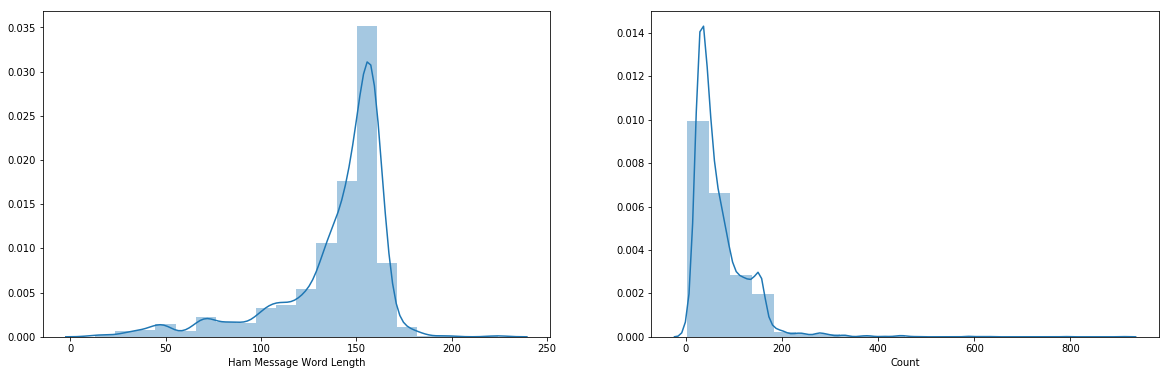

In [43]:
f, ax = plt.subplots(1, 2, figsize = (20, 6))

sns.distplot(df[df["label"] == 1]["Count"], bins = 20, ax = ax[0])
ax[0].set_xlabel("Spam Message Word Length")

sns.distplot(df[df["label"] == 0]["Count"], bins = 20, ax = ax[1])
ax[0].set_xlabel("Ham Message Word Length")

plt.show()

Deduction: 
    * Count can definetely can be considered as important feature towards determining whether the text is spam or not.
    * It seems that, spam messages are usually longer.
    * As, it seems that messages above count 250 are definetely SPAM

In [12]:
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

In [13]:
df.head()

,label,text,Count
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


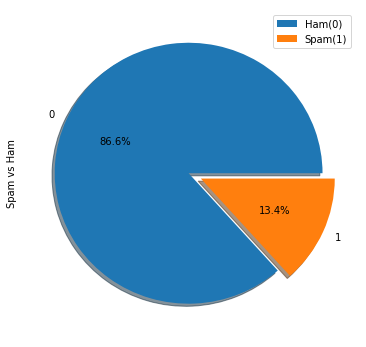

In [22]:
df["label"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Spam vs Ham")
plt.legend(["Ham(0)", "Spam(1)"])
plt.show()

A lot of messages are actually not spam. About 86% of our dataset consists of normal messages.

As our data is pretty much imbalanced more towards Ham(0), I have determined to use Stratified Sampling such that our model should not predict text as only ham.

In [26]:
top_text = df.groupby("text")["label"].agg([len, np.max]).sort_values(by = "len", ascending = False).head(n = 10)
display(top_text)

,len,amax
text,,
"Sorry, I'll call later",30,0
I cant pick the phone right now. Pls send a message,12,0
Ok...,10,0
Your opinion about me? 1. Over 2. Jada 3. Kusruthi 4. Lovable 5. Silent 6. Spl character 7. Not matured 8. Stylish 9. Simple Pls reply..,4,0
"Wen ur lovable bcums angry wid u, dnt take it seriously.. Coz being angry is d most childish n true way of showing deep affection, care n luv!.. kettoda manda... Have nice day da.",4,0
Please call our customer service representative on FREEPHONE 0808 145 4742 between 9am-11pm as you have WON a guaranteed å£1000 cash or å£5000 prize!,4,1
Okie,4,0
"Say this slowly.? GOD,I LOVE YOU &amp; I NEED YOU,CLEAN MY HEART WITH YOUR BLOOD.Send this to Ten special people &amp; u c miracle tomorrow, do it,pls,pls do it...",4,0
"7 wonders in My WORLD 7th You 6th Ur style 5th Ur smile 4th Ur Personality 3rd Ur Nature 2nd Ur SMS and 1st \Ur Lovely Friendship\""... good morning dear""",4,0


So. People are good at avoiding long conversations and delaying the tasks or they are just lazy. 

"Sorry, i'll call later" tops the ham message list with 30 counts and 

"I cant pick the phone right now. Pls send a message" comes second with 12 counts.

In [36]:
spam_messages = df[df["label"] == 1]["text"]
ham_messages = df[df["label"] == 0]["text"]

spam_words = []
ham_words = []

# Since this is just classifying the message as spam or ham, we can use isalpha(). 
# This will also remove the not word in something like can't etc. 
# In a sentiment analysis setting, its better to use 
# sentence.translate(string.maketrans("", "", ), chars_to_remove)

def extractSpamWords(spamMessages):
    global spam_words
    words = [word.lower() for word in word_tokenize(spamMessages) if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
    spam_words = spam_words + words
    
def extractHamWords(hamMessages):
    global ham_words
    words = [word.lower() for word in word_tokenize(hamMessages) if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
    ham_words = ham_words + words

spam_messages.apply(extractSpamWords)
ham_messages.apply(extractHamWords)

0       None
1       None
3       None
4       None
6       None
7       None
10      None
13      None
14      None
16      None
17      None
18      None
20      None
21      None
22      None
23      None
24      None
25      None
26      None
27      None
28      None
29      None
30      None
31      None
32      None
33      None
35      None
36      None
37      None
38      None
        ... 
5538    None
5539    None
5541    None
5542    None
5543    None
5544    None
5545    None
5546    None
5548    None
5549    None
5550    None
5551    None
5552    None
5553    None
5554    None
5555    None
5556    None
5557    None
5558    None
5559    None
5560    None
5561    None
5562    None
5563    None
5564    None
5565    None
5568    None
5569    None
5570    None
5571    None
Name: text, Length: 4825, dtype: object

###### Word CLoud

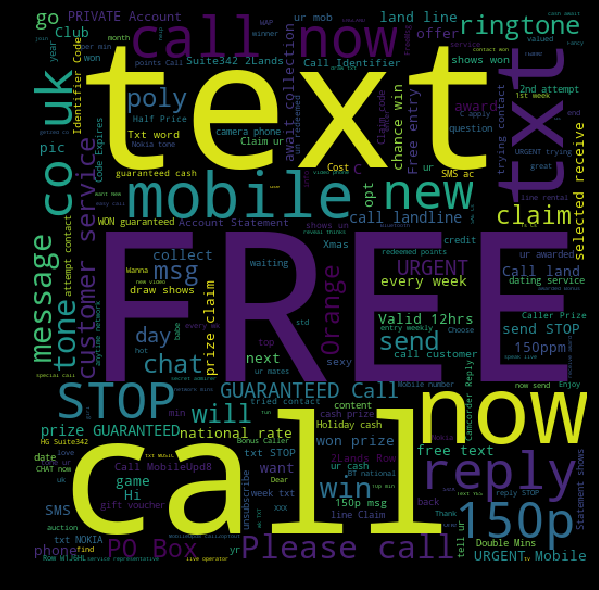

In [16]:
spam_words = ' '.join(list(df[df['label'] == 1]['text']))
spam_wc = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

###### Top 10 spam words

In [37]:
spam_words = np.array(spam_words)
print("Top 10 Spam words are :\n")
pd.Series(spam_words).value_counts().head(n = 10) 

Top 10 Spam words are :



call      346
free      217
txt       156
ur        144
u         144
mobile    123
text      121
stop      114
claim     113
reply     104
dtype: int64

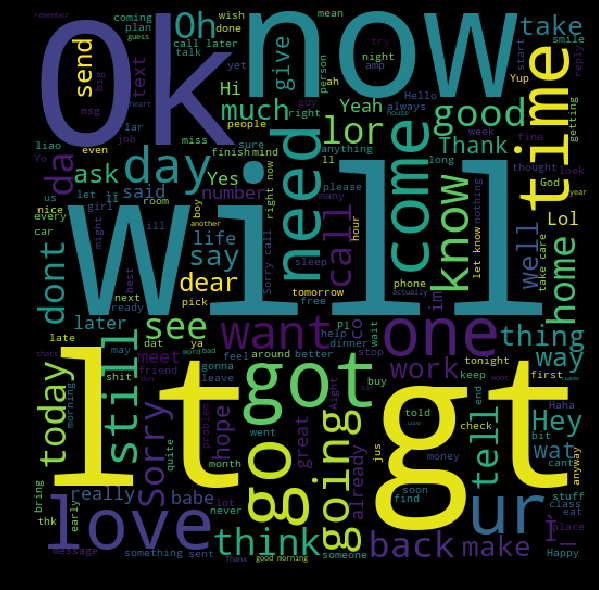

In [19]:
ham_words = ' '.join(list(df[df['label'] == 0]['text']))
ham_wc = WordCloud(width = 512,height = 512).generate(ham_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(ham_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

###### Top 10 Ham words

In [38]:
ham_words = np.array(ham_words)
print("Top 10 Ham words are :\n")
pd.Series(ham_words).value_counts().head(n = 10) 

Top 10 Ham words are :



u       974
gt      318
lt      316
get     301
ok      246
go      246
got     242
ur      237
know    234
like    231
dtype: int64

# b.	Make sure that you split the data in to train (70%) and test (30%). Use random_state=100, while using train_test_split function to set the seed

### Model Builing & Text Processing

In [44]:
def pre_process(text):
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    words = ""
    for i in text:
            stemmer = SnowballStemmer("english")
            words += (stemmer.stem(i))+" "
    return words

#### Train_Test SPlit

In [46]:
textFeatures = df['text'].copy()
textFeatures = textFeatures.apply(pre_process)
vectorizer = TfidfVectorizer("english")
features = vectorizer.fit_transform(textFeatures)

features_train, features_test, labels_train, labels_test = train_test_split(features, df['label'], test_size=0.3, random_state=10)

###### Applying Decision Tree

In [62]:
dt = DecisionTreeClassifier(random_state=50)
dt.fit(features_train, labels_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=50,
            splitter='best')

In [63]:
# Predicting
y_pred_dt = dt.predict(features_test)

In [64]:
# Evaluating
cm_dt = confusion_matrix(labels_test, y_pred_dt)

print(cm_dt)

[[1403   43]
 [  42  184]]


In [65]:
specificity_dt = cm_dt[1,1]/(cm_dt[1,0]+cm_dt[1,1])

In [66]:
print ("Accuracy : %0.5f \n\n" % accuracy_score(labels_test, dt.predict(features_test)))
print (classification_report(labels_test, dt.predict(features_test)))
print("Specificity : ",specificity_dt)

Accuracy : 0.94916 


             precision    recall  f1-score   support

          0       0.97      0.97      0.97      1446
          1       0.81      0.81      0.81       226

avg / total       0.95      0.95      0.95      1672

Specificity :  0.8141592920353983


###### Applying SVM (Support Vector Machine)

In [67]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

svc = SVC(kernel='sigmoid', gamma=1.0)
svc.fit(features_train, labels_train)
prediction = svc.predict(features_test)


In [68]:
# Evaluating
cm_svm = confusion_matrix(labels_test, y_pred_dt)

print(cm_svm)

[[1403   43]
 [  42  184]]


In [69]:
specificity_svm = cm_svm[1,1]/(cm_svm[1,0]+cm_svm[1,1])

In [70]:
print ("Accuracy : %0.5f \n\n" % accuracy_score(labels_test, prediction))
print (classification_report(labels_test, prediction))
print("Specificity : ",specificity)

Accuracy : 0.97847 


             precision    recall  f1-score   support

          0       0.98      1.00      0.99      1446
          1       0.98      0.86      0.92       226

avg / total       0.98      0.98      0.98      1672

Specificity :  0.8141592920353983


# accuracy of the model to above 96% : Acheived